In [152]:
from google.colab import drive
drive.mount('/content/drive', force_remount = False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [153]:
# extract data from zip file
import zipfile
import os

# Define the path to your zip file and the directory where you want to extract it
zip_file_path = '/content/drive/MyDrive/465 Project/new_archive.zip'
extract_folder_path = '/content/data'

os.makedirs(extract_folder_path, exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder_path)


In [154]:
# lib imports
import torch
import os
import numpy as np
import pandas as pd
import random
import cv2

from tqdm import tqdm

from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

In [155]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

In [156]:
# Set the directories containing the images and masks
image_dir = '/content/data/GRAIN DATA SET/RG'
mask_dir = '/content/data/GRAIN DATA SET/RGMask'

# Set the target image size
target_size = (IMG_WIDTH, IMG_HEIGHT)

# Create empty lists to hold the images and masks
images = []
masks = []

# Iterate through the directories and load the images and masks
for file in sorted(os.listdir(image_dir)):
    # Load the image and resize to the target size
    img = cv2.imread(os.path.join(image_dir, file))
    img = cv2.resize(img, target_size)

    # Append the resized image to the list of images
    images.append(img)

for file in sorted(os.listdir(mask_dir)):

    # Load the corresponding mask and resize to the target size
    #mask_file = file.replace('.jpg', '.png')
    mask = cv2.imread(os.path.join(mask_dir, file))
    mask = cv2.resize(mask, target_size)

    # Append the resized mask to the list of masks
    masks.append(mask)

In [157]:
# create the X and Y (input and output)

X_train = np.array(images)
Y_train = np.array(masks)
print(X_train.shape, Y_train.shape)
# change the Y to a boolean
Y_train = np.where(Y_train > 245, True, False)

(480, 128, 128, 3) (480, 128, 128, 3)


In [158]:
image_x = random.randint(0, 300)
image_x

70

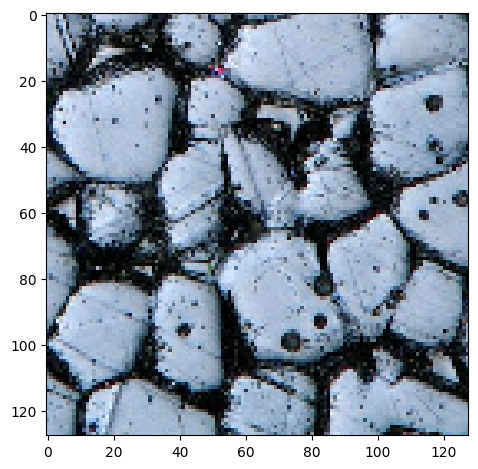

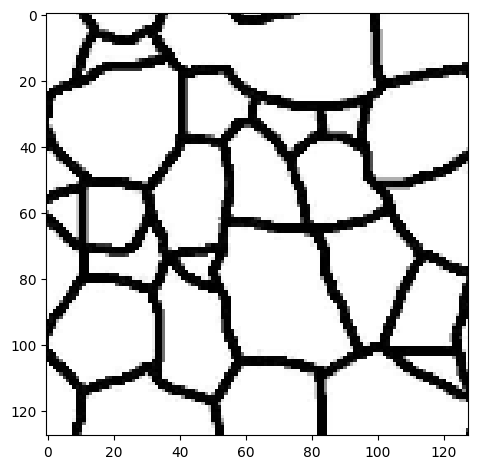

In [159]:
# example
imshow(images[image_x])
plt.show()
imshow(masks[image_x])
plt.show()

In [160]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        # Contraction path
        self.conv1 = self.contracting_block(in_channels, 16)
        self.conv2 = self.contracting_block(16, 32)
        self.conv3 = self.contracting_block(32, 64)
        self.conv4 = self.contracting_block(64, 128)
        self.conv5 = self.contracting_block(128, 256)


        # Expansive path
        self.upconv6 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv6 = self.expansive_block(256, 128)
        self.upconv7 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv7 = self.expansive_block(128, 64)
        self.upconv8 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.conv8 = self.expansive_block(64, 32)
        self.upconv9 = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2)
        self.conv9 = self.expansive_block(32, 16)

        # Output layer
        self.output_conv = nn.Conv2d(16, out_channels, kernel_size=1)

    def contracting_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),
        )

    def expansive_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1)
        )

    def forward(self, x):
        # Contraction path
        mx_pool = nn.MaxPool2d(kernel_size=2)
        c1 = self.conv1(x)
        p1 = mx_pool(c1)
        c2 = self.conv2(p1)
        p2 = mx_pool(c2)
        c3 = self.conv3(p2)
        p3 = mx_pool(c3)
        c4 = self.conv4(p3)
        p4 = mx_pool(c4)
        c5 = self.conv5(p4)

        # Expansive path
        u6 = self.upconv6(c5)
        # print(c5.shape)
        # print(u6.shape, c4.shape) # for debugging
        u6 = torch.cat([u6, c4], dim=1)
        c6 = self.conv6(u6)
        u7 = self.upconv7(c6)
        u7 = torch.cat([u7, c3], dim=1)
        c7 = self.conv7(u7)
        u8 = self.upconv8(c7)
        u8 = torch.cat([u8, c2], dim=1)
        c8 = self.conv8(u8)
        u9 = self.upconv9(c8)
        u9 = torch.cat([u9, c1], dim=1)
        c9 = self.conv9(u9)

        # Output layer
        outputs = self.output_conv(c9)
        return torch.sigmoid(outputs)


# Instantiate the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model = UNet(IMG_CHANNELS, 1).to(device)

# print(model)

In [161]:
from torchsummary import summary
summary(model, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 128]             448
              ReLU-2         [-1, 16, 128, 128]               0
            Conv2d-3         [-1, 16, 128, 128]           2,320
              ReLU-4         [-1, 16, 128, 128]               0
           Dropout-5         [-1, 16, 128, 128]               0
            Conv2d-6           [-1, 32, 64, 64]           4,640
              ReLU-7           [-1, 32, 64, 64]               0
            Conv2d-8           [-1, 32, 64, 64]           9,248
              ReLU-9           [-1, 32, 64, 64]               0
          Dropout-10           [-1, 32, 64, 64]               0
           Conv2d-11           [-1, 64, 32, 32]          18,496
             ReLU-12           [-1, 64, 32, 32]               0
           Conv2d-13           [-1, 64, 32, 32]          36,928
             ReLU-14           [-1, 64,

In [162]:
# create the X and Y (input and output)

X_train = np.array(images)
Y_train = np.array(masks)
print(X_train.shape, Y_train.shape)
# change the Y to a boolean
Y_train = np.where(Y_train > 245, True, False)

(480, 128, 128, 3) (480, 128, 128, 3)


In [163]:
# careful to run this cell only once (otherwise shape changes)
X_train = np.transpose(X_train, (0, 3, 1 , 2))
Y_train = np.transpose(Y_train, (0, 3, 1 , 2))
print(X_train.shape, Y_train.shape)

(480, 3, 128, 128) (480, 3, 128, 128)


In [164]:
#convert the boolean where it insion s true (any of the 3 channels) to a (336, 128, 128, 1)
#basically reduce the 3 channel dimeRGB to just one boolean value

Y_t= np.any(Y_train, axis=1)
print(Y_t.shape)
Y_t = Y_t.reshape(480, 1, 128, 128)
print(Y_t.shape)


(480, 128, 128)
(480, 1, 128, 128)


In [165]:
################################

# create the checkpoint path

# checkpoint_path = '/content/checkpoint_path/GrainsTraining.pt'
# os.makedirs("/content/checkpoint_path", exist_ok=True)
# checkpoint_dir = os.path.dirname(checkpoint_path)


In [166]:
# prompt: Make Dataset from data

from torch.utils.data import Dataset

class GrainDataset(Dataset):
    def __init__(self, images, masks):
        self.images = images
        self.masks = masks

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = torch.from_numpy(self.images[idx]).float()
        mask = torch.from_numpy(self.masks[idx]).float()
        return image, mask

# Create the dataset
dataset = GrainDataset(X_train, Y_t)



In [167]:
# prompt: create train and validation dataset

from torch.utils.data import random_split

# Split the dataset into train and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])



In [168]:
import torch.optim as optim
from torch.utils.data import DataLoader

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters())
criterion = nn.BCELoss()

# Define DataLoader for training and validation sets
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Define callbacks
class ModelCheckpoint:
    def __init__(self, checkpoint_path):
        self.checkpoint_path = checkpoint_path
        self.best_loss = float('inf')

    def __call__(self, model, epoch, train_loss, val_loss):
        if val_loss < self.best_loss:
            torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'train_loss' : train_loss,
            'val_loss': val_loss,
            }, self.checkpoint_path)
            print("Checkpoint saved")
            self.best_loss = val_loss

from datetime import datetime
checkpoint_path = f'/content/drive/MyDrive/465 Project/GrainsTraining{datetime.now().strftime("%d%m%Y %H:%M:%S")}.pt'
# print(checkpoint_path)
# os.makedirs("/content/drive/MyDrive/465 Project", exist_ok=True) # already exists
checkpoint_dir = os.path.dirname(checkpoint_path)

checkpointer = ModelCheckpoint(checkpoint_path)

# Training loop
num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    # Training
    for inputs, targets in train_loader:
        if device == 'cuda':
            inputs, targets = inputs.cuda(), targets.cuda()
        optimizer.zero_grad()
        # print(inputs.shape)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            if device == 'cuda':
                inputs, targets = inputs.cuda(), targets.cuda()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * inputs.size(0)

    # Average losses
    train_loss /= len(train_loader.dataset)
    val_loss /= len(val_loader.dataset)

    # Print epoch statistics
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    # Call the ModelCheckpoint callback
    checkpointer(model,epoch, train_loss, val_loss)


Epoch [1/30], Train Loss: 0.4327, Val Loss: 0.3836
Checkpoint saved
Epoch [2/30], Train Loss: 0.3790, Val Loss: 0.3705
Checkpoint saved
Epoch [3/30], Train Loss: 0.3671, Val Loss: 0.3614
Checkpoint saved
Epoch [4/30], Train Loss: 0.3480, Val Loss: 0.3368
Checkpoint saved
Epoch [5/30], Train Loss: 0.3297, Val Loss: 0.3295
Checkpoint saved
Epoch [6/30], Train Loss: 0.3208, Val Loss: 0.3198
Checkpoint saved
Epoch [7/30], Train Loss: 0.3153, Val Loss: 0.3201
Epoch [8/30], Train Loss: 0.3102, Val Loss: 0.3118
Checkpoint saved
Epoch [9/30], Train Loss: 0.3059, Val Loss: 0.3166
Epoch [10/30], Train Loss: 0.3043, Val Loss: 0.3093
Checkpoint saved
Epoch [11/30], Train Loss: 0.3018, Val Loss: 0.3096
Epoch [12/30], Train Loss: 0.2993, Val Loss: 0.3094
Epoch [13/30], Train Loss: 0.2980, Val Loss: 0.3097
Epoch [14/30], Train Loss: 0.2962, Val Loss: 0.3046
Checkpoint saved
Epoch [15/30], Train Loss: 0.2936, Val Loss: 0.3066
Epoch [16/30], Train Loss: 0.2931, Val Loss: 0.3064
Epoch [17/30], Train Los

In [169]:
model.eval()

UNet(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Dropout(p=0.1, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Dropout(p=0.1, inplace=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Dropout(p=0.1, inplace=False)
  )
  (conv4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride

In [170]:
# Set model to evaluation mode
model.eval()

# Select a random index for demonstration
idx = random.randint(0, len(X_train))
print(f"Input data type: {X_train.dtype}")
# Perform predictions on training and validation data
with torch.no_grad():
    preds_train_tensor = model(torch.tensor(X_train[:int(X_train.shape[0]*0.9)], dtype=torch.float32).cuda())
    preds_val_tensor = model(torch.tensor(X_train[int(X_train.shape[0]*0.9):], dtype=torch.float32).cuda())

# Convert predictions to numpy arrays and apply thresholding
preds_train_np = (preds_train_tensor.cpu().numpy() > 0.5).astype(np.uint8)
preds_val_np = (preds_val_tensor.cpu().numpy() > 0.5).astype(np.uint8)

Input data type: uint8


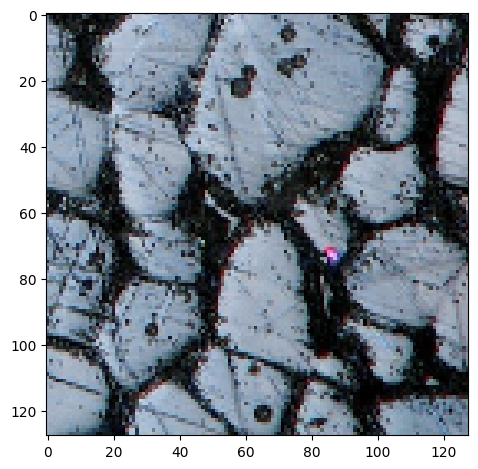

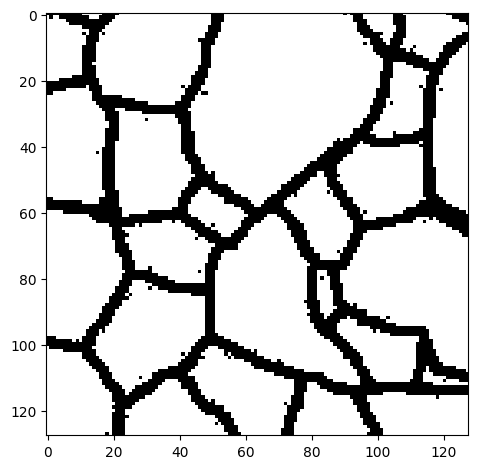

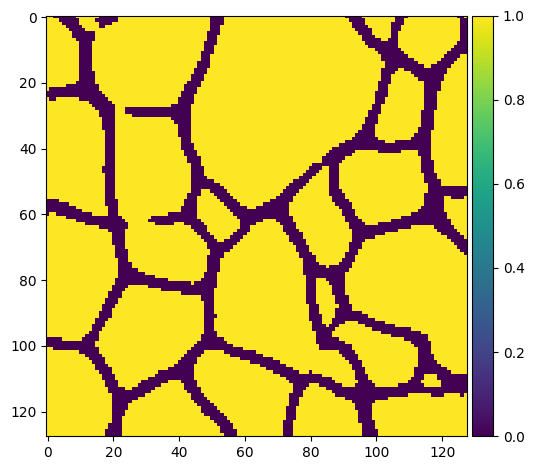

In [171]:

ix = random.randint(0, len(preds_train_np))
imshow(np.transpose(X_train[ix], (1, 2, 0)))
plt.show()
imshow(np.squeeze(Y_t[ix]))
plt.show()
imshow(np.squeeze(preds_train_np[ix]))
plt.show()

In [172]:
import torch
checkpoint_path = '/content/drive/MyDrive/465 project demo 1/Unet ckpts/GrainsTraining28032024 19_16_04.pt'  # Adjust this path accordingly
saved_model_ckpt = torch.load(checkpoint_path, map_location=torch.device('cpu'))
saved_model = UNet(IMG_CHANNELS, 1).to(device)
saved_model.load_state_dict(saved_model_ckpt['model_state_dict'])
epoch = saved_model_ckpt['epoch']
train_loss = saved_model_ckpt['train_loss']
val_loss = saved_model_ckpt['val_loss']
print(train_loss, val_loss)
saved_model.eval()


0.29139862709970615 0.2915489428183612


UNet(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Dropout(p=0.1, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Dropout(p=0.1, inplace=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Dropout(p=0.1, inplace=False)
  )
  (conv4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride

In [173]:
import pandas as pd
import torch

# Load the saved model checkpoint
checkpoint_path = '/content/drive/MyDrive/465 project demo 1/Unet ckpts/GrainsTraining28032024 19_16_04.pt'  # Adjust this path accordingly
checkpoint = torch.load(checkpoint_path)
# print(checkpoint.keys())

# Extract specific information from the checkpoint
epoch = checkpoint['epoch']
train_loss = checkpoint['train_loss']
val_loss = checkpoint['val_loss']

# Create a DataFrame for the training and validation loss
loss_data = {'Epoch': [epoch], 'Training Loss': [train_loss], 'Validation Loss': [val_loss]}
loss_df = pd.DataFrame(loss_data)

# Print the DataFrame in Markdown table format
print(loss_df.to_markdown(index=False))


|   Epoch |   Training Loss |   Validation Loss |
|--------:|----------------:|------------------:|
|      18 |        0.291399 |          0.291549 |


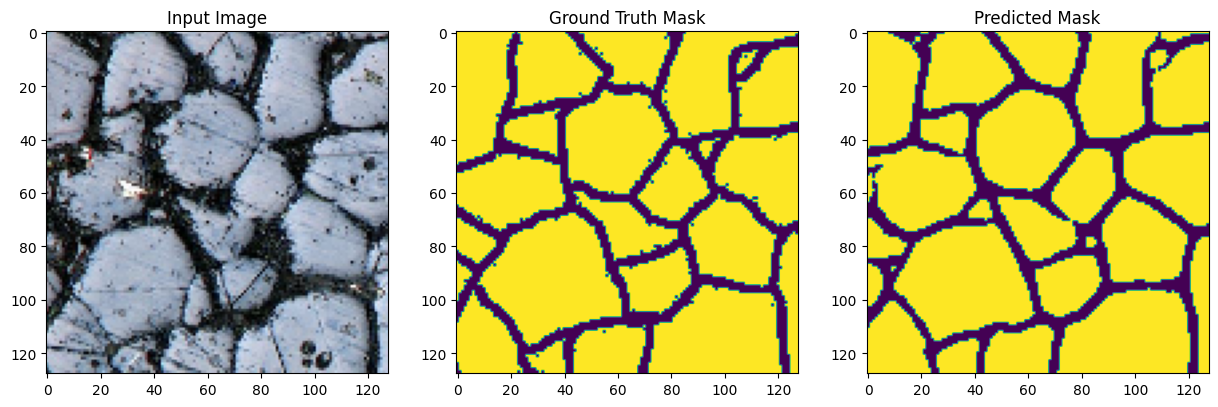

In [174]:
import matplotlib.pyplot as plt
import random

def display_results(image, ground_truth_mask, predicted_mask):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Display input image
    axes[0].imshow(np.transpose(image, (1, 2, 0)))
    axes[0].set_title('Input Image')

    # Display ground truth mask
    axes[1].imshow(np.squeeze(ground_truth_mask))
    axes[1].set_title('Ground Truth Mask')

    # Display predicted mask
    axes[2].imshow(np.squeeze(predicted_mask))
    axes[2].set_title('Predicted Mask')

    plt.show()

# Select a random index for demonstration
idx = random.randint(0, len(X_train))

# Display results for the selected index
display_results(X_train[idx], Y_t[idx], preds_train_np[idx])

In [175]:
!pip install torchmetrics

In [176]:
from torchmetrics.functional import dice
from torchmetrics.functional import jaccard_index

total_jaccard_score = 0.0
total_dice_score = 0.0
total_num_samples = 0

for images, masks in val_loader:
    batch_size = images.size(0)  # Get the actual batch size
    total_num_samples += batch_size

    with torch.no_grad():
        images = images.to(device)
        masks = masks.to(device)

        # Forward pass
        preds = model(images)

        for ind in range(len(preds)):
            pred_tensor = (preds[ind] > 0.5).float()
            gt_tensor = masks[ind].to(torch.int64)  # Convert mask tensor to integer tensor

            dice_score = dice(pred_tensor, gt_tensor)
            total_dice_score += dice_score.item()

            jaccard_score = jaccard_index(pred_tensor, gt_tensor, task='binary')
            total_jaccard_score += jaccard_score.item()

average_dice_score = total_dice_score / total_num_samples
average_jaccard_score = total_jaccard_score / total_num_samples


print(f"Total Number samples: {total_num_samples}")
print(f"Average Dice Score: {average_dice_score}")
print(f"Average Jaccard Index: {average_jaccard_score}")

Total Number samples: 96
Average Dice Score: 0.9050781993816296
Average Jaccard Index: 0.8269849220911661
